In [57]:
# Load necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit, OptimizeWarning
import warnings
from sklearn.metrics import mean_squared_error
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)


In [2]:
## Load and sort data

# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april13_50mM_DAB2_418_630_150mM_NaCl_1DCVJ_slow_hysteresis/'

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Load data from each file
for file_path in data_files:
    loaded_data.append(load_data(file_path))

titles = []

# Extract 6th to 4th last digits from file name and use as title
titles = [int(file_path.split('/')[-1].split('.')[0][-7:-4]) for file_path in data_files]

# Sort the titles and data_files in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
data_files = [data_files[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Sort the files by their title
data_files.sort(key=lambda x: int(x.split('/')[-1].split('.')[0][-7:-4]))
    
# Check if file name contains "999" and assign it as baseline data
if "999" in file_path:
    baseline_data = loaded_data[-1]
    baseline_title = title
    
print(titles)

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][2:, 0].astype(float)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 999]


In [74]:
## Set Parameters

# Set the number of the first and last spectrum to use in the plot -1
first_spectrum = 0
last_spectrum = 31

# Define the x-values to extract (takes average of 10 data points)
x_values = [465, 535]

# Define the range of titles you want to use for the biexponential fit
start_title = 8
end_title = 31



## Extract respective intensities for chosen spectra and wavelenghts, averaged over 1nm

# Initialize lists to store y-values for each x-value for all spectra
y_values_all = [[] for _ in range(len(x_values))]

# Initialize lists to store x-values for each x-value for all spectra
x_values_all = [[] for _ in range(len(x_values))]

# Iterate through spectra between the first and last
for i, data in enumerate(loaded_data[first_spectrum:last_spectrum+1]):
    # Iterate through each specified x-value
    spectrum_index = first_spectrum + i
    spectrum_title = titles[spectrum_index]  # Assuming titles list is correctly populated
#   print(f"Spectrum Index: {spectrum_index}, Spectrum Title: {spectrum_title}")
    for j, x in enumerate(x_values):
        # Find the indices of the 10 closest x-values to the current x
        closest_indices = np.argsort(np.abs(data[:, 0] - x))[:10]
        # Extract the corresponding x-values
        closest_x_values = data[closest_indices, 0]
#       print(f"Closest x-values for x={x}: {closest_x_values}")
# Calculate the average x-value
        avg_x_value = np.mean(closest_x_values)
        x_values_all[j].append(avg_x_value)
        # Extract the corresponding y-values
        y_values = data[closest_indices, 1]
#       print(f"Closest y-values for x={x}: {y_values}")
        # Calculate the average y-value
        avg_y_value = np.mean(y_values)
#       print(f"Average y-value for x={x}: {avg_y_value}")
        # Store the average y-value
        y_values_all[j].append(avg_y_value)
print(f"Average y-values:", y_values_all)

#print(closest_indices)
closest_x_values = data[closest_indices, 0]
#print(f"Closest x-values for x={x}: {closest_x_values}")


## Convert extracted digits back to temperature values for the selected range of titles
temperatures = [10 + i * 0.5 for i, title in enumerate(titles) if first_spectrum <= i <= last_spectrum]


print("List of temperatures", temperatures)


# Extract the temperatures corresponding to the first and last spectrum indices
start_temperature = temperatures[first_spectrum]
end_temperature = temperatures[last_spectrum]

# Create a linspace numpy array with 100 values between the extracted temperatures
interpolation_temperatures = np.linspace(start_temperature, end_temperature, 200)

# Print the results
print("Start temperature:", start_temperature)
print("End temperature:", end_temperature)
print("Interpolation temperatures:", interpolation_temperatures)




## Define Models for Fits

# Generate a continuous range of x-values covering all data points for evaluation of fitted functions
# x_values_interp = np.linspace(0, len(y_values_all[0]) - 1, 200)

# print(x_values_interp)

# Initialize the array to store the interpolated y-values for all x-values
y_values_interp_all = []
y_values_exp_interp_all = []
y_values_biexp_interp_all = []

# Define the biexponential function
def biexponential(x, a1, b1, c1, a2, b2, d2):
    return a1 * np.exp(-b1 * x) + c1 + a2 * np.exp(-b2 * (x - d2))

# Exponential model function
def exp_func(x, a, b, c, d):
    return a * np.exp(-b * (x - c)) + d





## Prepare Data for fits

# Convert titles to numerical format if necessary
numeric_titles = [float(title) for title in titles]

# Initialize filtered temperatures list
filtered_temperatures_all = []

# Filter temperatures based on title range
for i, title in enumerate(numeric_titles):
    if start_title <= title <= end_title:
        filtered_temperatures_all.append(temperatures[i])

# Print filtered_temperatures_all
print(filtered_temperatures_all)

# Initialize filtered y-values list
filtered_y_values_all = [[] for _ in range(len(x_values))]

# Filter y_values_all based on title range
for i, title in enumerate(numeric_titles):
    if start_title <= title <= end_title:
        for j in range(len(x_values)):
            filtered_y_values_all[j].append(y_values_all[j][i])

# Print filtered_y_values_all
print(filtered_y_values_all)

# Round all y-values to two decimals
filtered_y_values_all = np.round(filtered_y_values_all, decimals=2)
print(filtered_y_values_all)


## Fit Polynomial Model

# Iterate over each set of y-values (corresponding to different x-values)
for y_values in y_values_all:
    # Construct polynomial function and get coefficients
    coeffs = np.polyfit(temperatures, y_values, 5)
    poly = np.poly1d(coeffs)
    
    # Evaluate the polynomial at the continuous x-values
    y_values_interp = poly(interpolation_temperatures)
    
    # Store the interpolated y-values for this x-value
    y_values_interp_all.append(y_values_interp)


print(y_values_interp_all)

## Fit exponential model

# Define a function to generate random initial guesses
def generate_random_initial_guess():
    # Generate random values within specified ranges
    a_guess = np.random.uniform(0, 1000)
    b_guess = np.random.uniform(0, 1)
    c_guess = np.random.uniform(-end_temperature, end_temperature)
    d_guess = np.random.uniform(0, 1000)
    return [a_guess, b_guess, c_guess, d_guess]

# Define a function to fit the data with exponential function
def fit_exponential(filtered_temperatures, filtered_y_values, method, initial_guess):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('error', OptimizeWarning)
            exp_popt, exp_pcov = curve_fit(exp_func, filtered_temperatures, filtered_y_values, p0=initial_guess, method=method)
            return exp_popt, exp_pcov
    except (RuntimeError, ValueError, OptimizeWarning):
        return None, None

# Function to calculate R^2
def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared


    # Define a function to fit the data with exponential function
def fit_exponential_with_retry(filtered_temperatures_all, filtered_y_values_all):
    max_attempts = 500
    params_exp_all = []
    r_squared_values = []
    methods = ['lm', 'trf', 'dogbox']
    for j in range(len(x_values)):
        filtered_temperatures = np.array(filtered_temperatures_all)
        filtered_y_values = np.array(filtered_y_values_all[j])
        success = False
        attempts = 0

        initial_guess = [max(filtered_y_values), 0.1, np.mean(filtered_temperatures), np.mean(filtered_y_values)]

        while attempts < max_attempts and not success:
            for method in methods:
                print(f"Attempt {attempts+1}, Method: {method}, Initial Guess: {initial_guess}")

                exp_popt, exp_pcov = fit_exponential(filtered_temperatures, filtered_y_values, method, initial_guess)

                if exp_popt is not None:
                    success = True
                    break  # Exit the for loop if successful

            if success:
                break  # Exit the while loop if successful

            # Generate a new initial guess after trying all methods
            initial_guess = generate_random_initial_guess()
            attempts += 1  # Increment attempts counter after all methods for one guess

        if success:
            params_exp_all.append(exp_popt)  # Store fit parameters
            y_values_exp_interp = exp_func(interpolation_temperatures, *exp_popt)  # Evaluate fitted function for plotting
            y_values_exp_interp_all.append(y_values_exp_interp)  # Append to list of fitted values for other spectra

            # Calculate R^2
            y_pred = exp_func(filtered_temperatures, *exp_popt)
            r_squared = calculate_r_squared(filtered_y_values, y_pred)
            r_squared_values.append(r_squared)  # Store R^2 value
            
        else:
            print("Optimization failed on all attempts.")
            return None, None

    return params_exp_all, y_values_exp_interp_all, r_squared_values

# Fit the data
params_exp_all, y_values_exp_interp_all, r_squared_values = fit_exponential_with_retry(filtered_temperatures_all, filtered_y_values_all)

print(f"Exponentially interpolated data", y_values_exp_interp_all)





# Define the biexponential function
def biexponential(x, a1, b1, c1, a2, b2, d2):
    return a1 * np.exp(-b1 * x) + c1 + a2 * np.exp(-b2 * (x - d2))




## Fit biexponential model

# Define a function to generate random initial guesses
def biexp_generate_random_initial_guess():
    # Generate random values within specified ranges
    a1_guess = np.random.uniform(0, 1000)
    b1_guess = np.random.uniform(0, 1)    
    c1_guess = np.random.uniform(0, 1000)
    a2_guess = np.random.uniform(0, 1000)
    b2_guess = np.random.uniform(0, 1)
    d2_guess = np.random.uniform(-end_temperature, end_temperature)
    return [a1_guess, b1_guess, c1_guess, a2_guess, b2_guess, d2_guess]

# Define a function to fit the data with exponential function
def fit_biexponential(filtered_temperatures, filtered_y_values, method, initial_guess):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter('error', category=OptimizeWarning)
            warnings.simplefilter('error', category=RuntimeWarning)
            biexp_popt, biexp_pcov = curve_fit(biexponential, filtered_temperatures, filtered_y_values, p0=initial_guess, method=method)
            return biexp_popt, biexp_pcov
    except (RuntimeError, ValueError, OptimizeWarning):
        return None, None

# Function to calculate R^2
def calculate_biexp_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    biexp_r_squared = 1 - (ss_res / ss_tot)
    return biexp_r_squared

    # Define a function to fit the data with exponential function
def fit_biexponential_with_retry(filtered_temperatures_all, filtered_y_values_all):
    max_attempts = 500
    params_biexp_all = []
    r_squared_values = []
    methods = ['lm', 'trf', 'dogbox']
    for j in range(len(x_values)):
        filtered_temperatures = np.array(filtered_temperatures_all)
        filtered_y_values = np.array(filtered_y_values_all[j])
        success = False
        attempts = 0

        initial_guess = [max(filtered_y_values), 0.1, np.mean(filtered_temperatures), max(filtered_y_values), 0.1,  np.mean(filtered_y_values)]

        while attempts < max_attempts and not success:
            for method in methods:
                print(f"Attempt {attempts+1}, Method: {method}, Initial Guess: {initial_guess}")

                biexp_popt, biexp_pcov = fit_biexponential(filtered_temperatures, filtered_y_values, method, initial_guess)

                if biexp_popt is not None:
                    success = True
                    break  # Exit the for loop if successful

            if success:
                break  # Exit the while loop if successful

            # Generate a new initial guess after trying all methods
            initial_guess = biexp_generate_random_initial_guess()
            attempts += 1  # Increment attempts counter after all methods for one guess

        if success:
            params_biexp_all.append(biexp_popt)  # Store fit parameters
            y_values_biexp_interp = biexponential(interpolation_temperatures, *biexp_popt)  # Evaluate fitted function for plotting
            y_values_biexp_interp_all.append(y_values_biexp_interp)  # Append to list of fitted values for other spectra

            # Calculate R^2
            y_pred = biexponential(filtered_temperatures, *biexp_popt)
            biexp_r_squared = calculate_biexp_r_squared(filtered_y_values, y_pred)
            biexp_r_squared_values.append(biexp_r_squared)  # Store R^2 value
            
        else:
            print("Optimization failed on all attempts.")
            return None, None

    return params_biexp_all, y_values_biexp_interp_all, biexp_r_squared_values

# Fit the data
params_biexp_all, y_values_biexp_interp_all, biexp_r_squared_values = fit_biexponential_with_retry(filtered_temperatures_all, filtered_y_values_all)

print(f"Biexponentially interpolated data", y_values_biexp_interp_all)



Average y-values: [[423.0416, 431.4777, 451.096, 481.7503, 506.37090000000006, 525.9091000000001, 495.9603, 498.67639999999994, 462.57519999999994, 419.23369999999994, 381.8616, 307.7102, 235.55839999999998, 204.37900000000002, 195.6081, 177.1061, 160.2024, 154.4918, 144.49539999999996, 143.99970000000002, 145.2141, 135.4279, 136.55490000000003, 129.44490000000002, 127.0415, 123.40859999999998, 121.04100000000001, 122.9365, 118.0837, 112.383, 111.109, 298.8383], [224.82930000000002, 212.3168, 214.2502, 215.24500000000003, 219.11010000000002, 218.8272, 202.3894, 200.21890000000002, 189.85380000000004, 188.6805, 166.3858, 153.57430000000005, 141.6951, 130.10240000000002, 123.7301, 121.002, 117.828, 112.29920000000001, 111.0444, 108.7105, 107.3886, 104.6617, 103.7737, 101.74324, 99.22576, 99.01657, 97.38140999999999, 97.15183000000002, 94.26642000000001, 92.50715, 91.93906000000001, 72.53603999999999]]
List of temperatures [10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0,

RuntimeWarning: overflow encountered in exp

/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/x_value_fits.svg


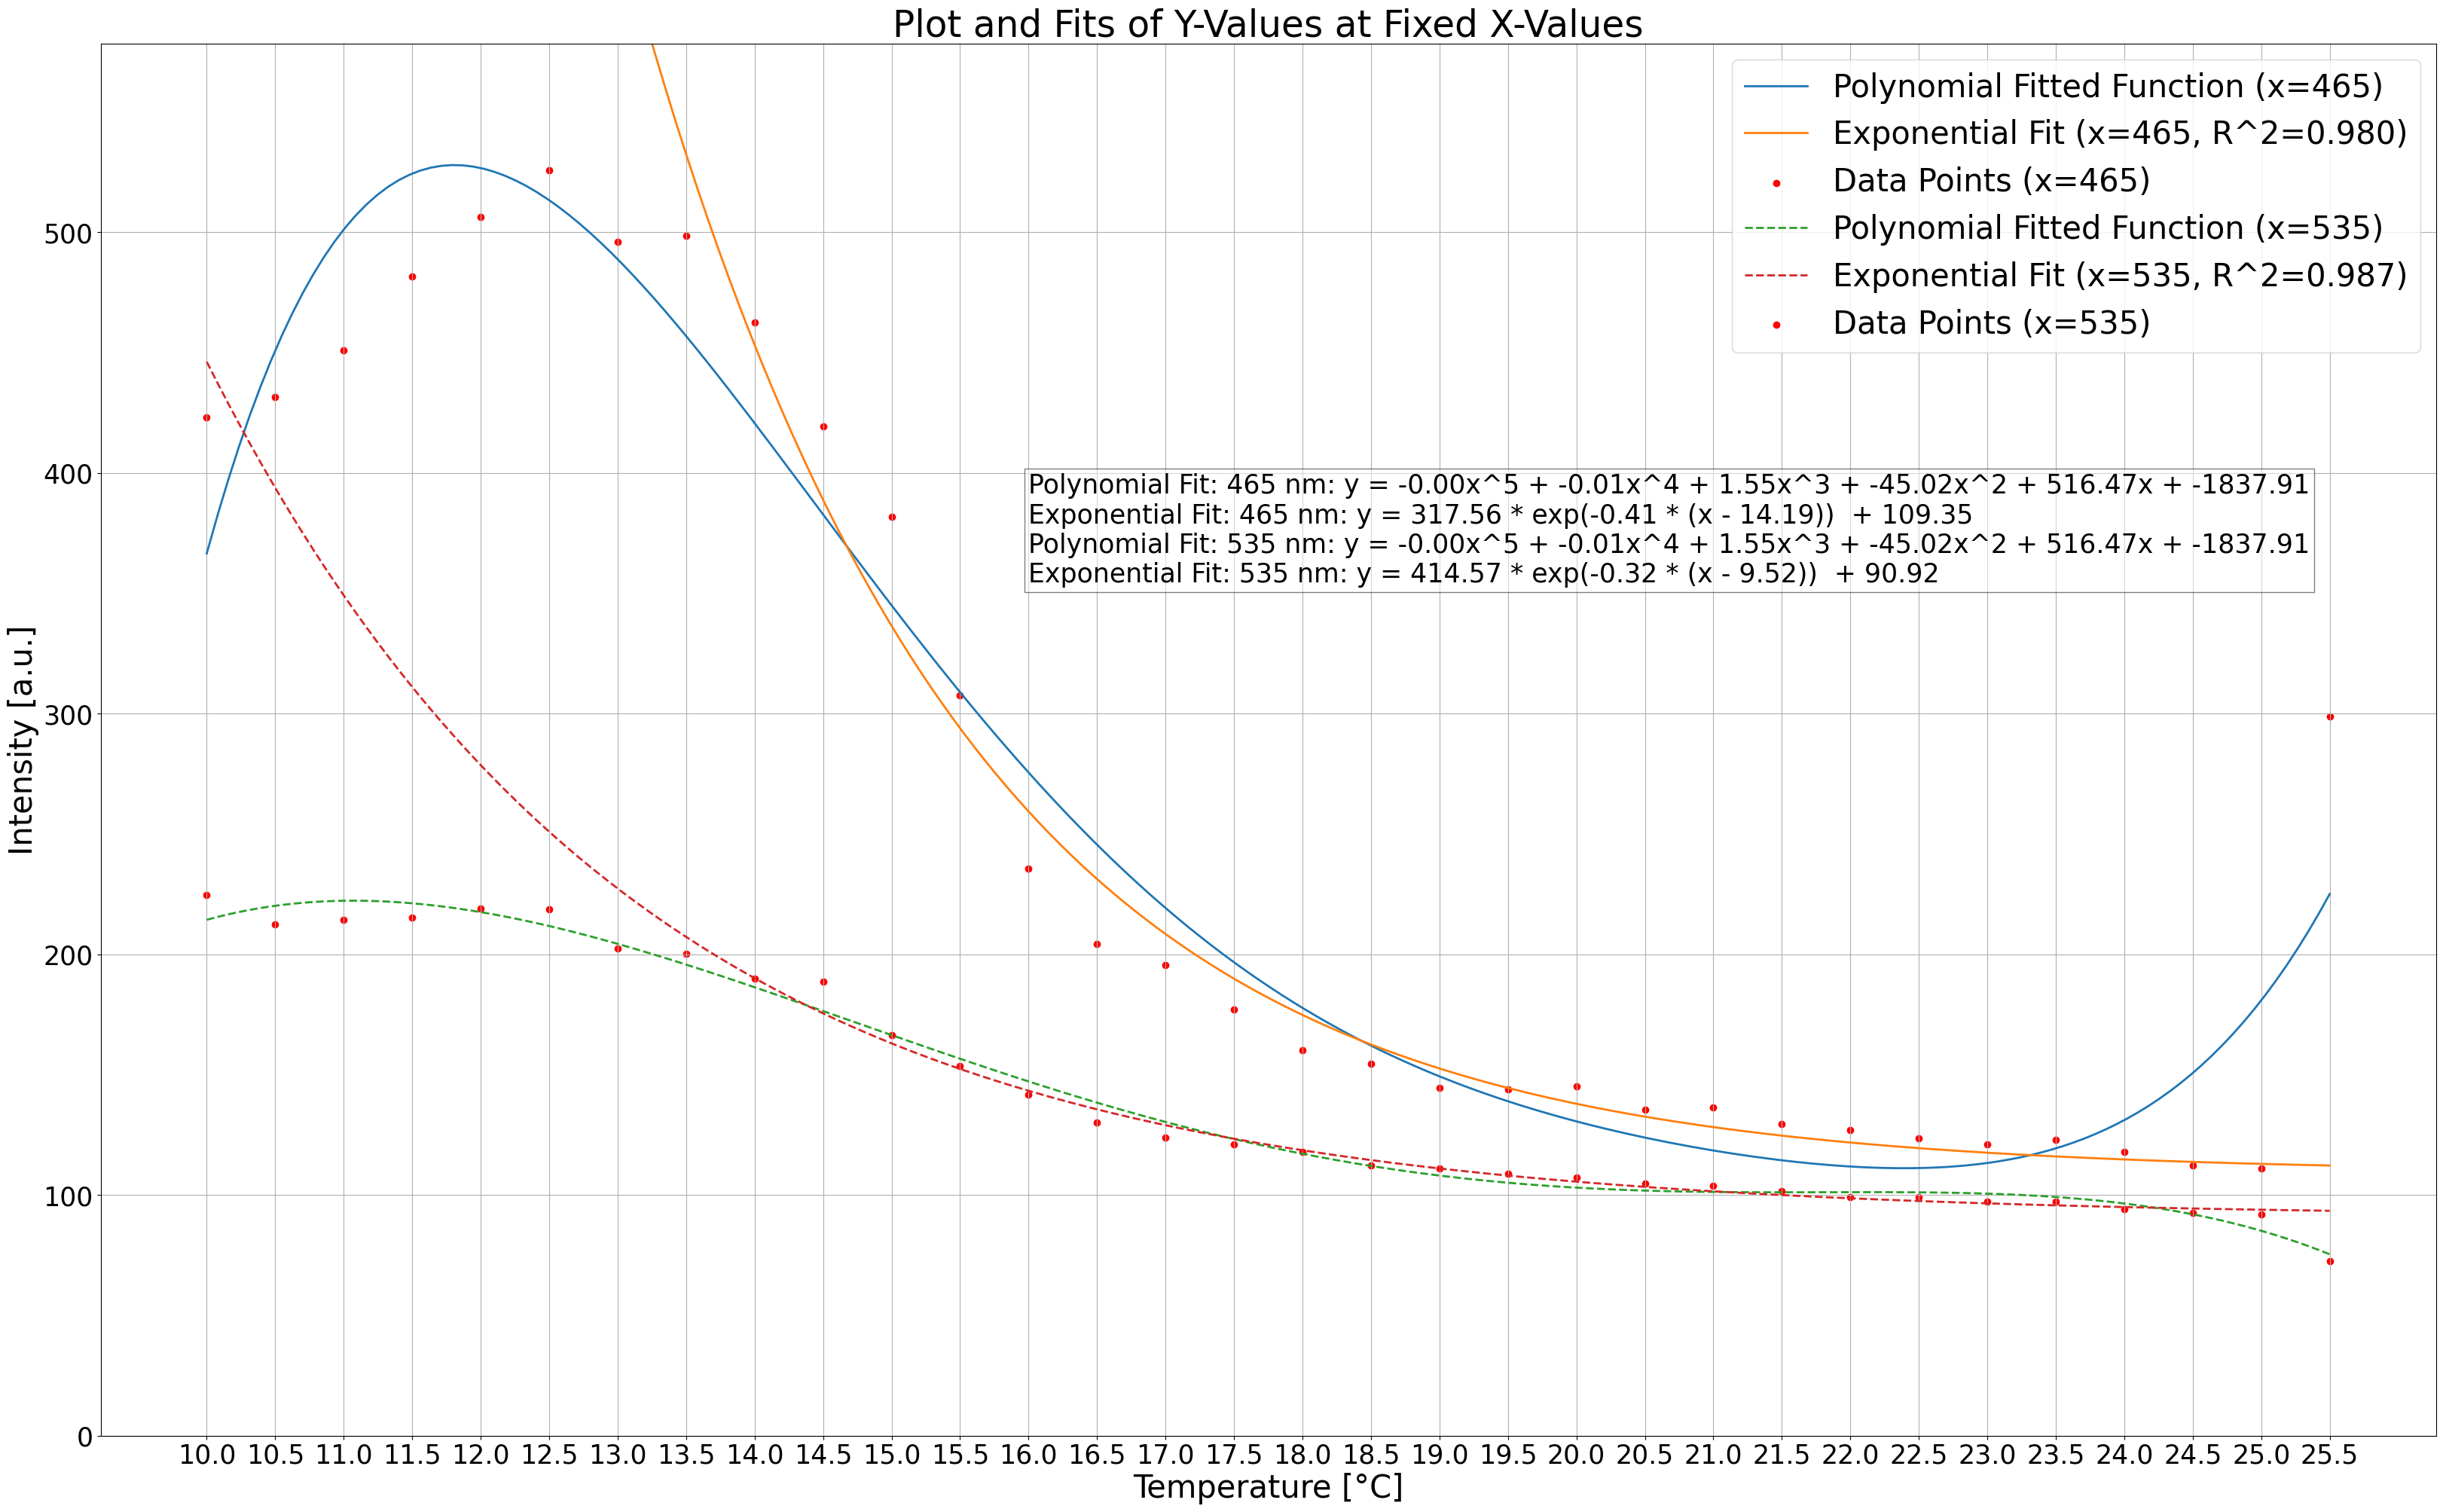

In [60]:
## Plot data series and fits


# Find temperatures of the first and last spectrum
first_temp = 10 + first_spectrum * 0.5
last_temp = 10 + last_spectrum * 0.5

# Define more line styles for interpolation curves
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--']


# Find maximum y-value in the scatter plot data
max_y_value = max(max(y) for y in y_values_all)

# Calculate 10% above the maximum y-value
y_upper_limit = max_y_value * 1.1  # 10% above the maximum value

# Plot interpolation curve for each x-value
plt.figure(figsize=(40, 24))

for i, x in enumerate(x_values):
# Choose line style for polynomial fit
    poly_line_style = line_styles[i]  # Cycle through line styles
# Choose line style for exponential fit
    exp_line_style = line_styles[len(x_values) + i]  # Cycle through line styles after the polynomial fits
# Choose line style for biexponential fit
    biexp_line_style = line_styles[2*len(x_values) + i]  # Cycle through line styles after the polynomial fits
      
# Plot interpolation curve for the current x-value
    plt.plot(interpolation_temperatures, y_values_interp_all[i], label=f'Polynomial Fitted Function (x={x})', linewidth=2, linestyle=poly_line_style)
# Plot biexp interpolation curve for the current x-value
    plt.plot(interpolation_temperatures, y_values_exp_interp_all[i], label=f'Exponential Fit (x={x}, R^2={r_squared_values[i]:.3f})', linewidth=2, linestyle=biexp_line_style)
 # Plot data points
    plt.scatter(temperatures, y_values_all[i], label=f'Data Points (x={x})', color='red')

## Display equations in a box

# Define equation_box as a global variable
equation_box = ""

# Function to populate equation_box
def populate_equation_box():
    global equation_box  # Declare equation_box as global within the function
    equation_box = ""  # Clear equation_box
    for i, x in enumerate(x_values):
        # Construct equation string
        exp_coeffs = params_exp_all[i]
        equation = f'Polynomial Fit: {x} nm: y = {coeffs[0]:.2f}x^5 + {coeffs[1]:.2f}x^4 + {coeffs[2]:.2f}x^3 + {coeffs[3]:.2f}x^2 + {coeffs[4]:.2f}x + {coeffs[5]:.2f}'
        equation_box += equation
        equation_box += '\n'
        exp_equation = f'Exponential Fit: {x} nm: y = {exp_coeffs[0]:.2f} * exp(-{exp_coeffs[1]:.2f} * (x - {exp_coeffs[2]:.2f}))  + {exp_coeffs[3]:.2f}'
        equation_box += exp_equation
        if j < len(x_values):
            equation_box += '\n'

# Populate equation_box
populate_equation_box()


# Define the position of the box
box_x = 16
box_y = 400
plt.text(box_x, box_y, equation_box, fontsize=25, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

 
plt.xlabel('Temperature [°C]', fontsize=30)
plt.ylabel('Intensity [a.u.]', fontsize=30)
plt.title('Plot and Fits of Y-Values at Fixed X-Values', fontsize=35)
plt.legend(fontsize=30)
# Adjust font size of grid numbers on axes
# Use temperatures for x-axis ticks
plt.xticks(temperatures, fontsize=25)
plt.yticks(fontsize=25)

# Set y-axis limits
plt.ylim(0, y_upper_limit)

plt.grid(True)

save_path = os.path.join(figure_dir, 'x_value_fits.svg')
print(save_path)
plt.savefig(save_path)
plt.show()


In [61]:
def svg_files_to_pdf(input_dir, output_dir, pdf_title):
    
    # Create a PDF canvas
    output_pdf_path = os.path.join(output_dir, f"{pdf_title}.pdf")
    c = canvas.Canvas(output_pdf_path, pagesize=landscape(letter))

    # Add title on the first page
    c.setFont("Helvetica-Bold", 20)
    c.drawCentredString(landscape(letter)[0] / 2.0, landscape(letter)[1] - 50, pdf_title)
#    c.showPage()  # Add a new page for the first SVG

    # Get list of all SVG files in the input directory
    svg_files = [f for f in os.listdir(figure_dir) if f.endswith('.svg')]

  # Parameters for arranging six images per page
    images_per_row = 2
    images_per_page = 4
    image_width = landscape(letter)[0] / images_per_row
    image_height = landscape(letter)[1] / (images_per_page // images_per_row)

    for i, svg_file in enumerate(svg_files):
        if i % images_per_page == 0 and i != 0:
            c.showPage()  # Add a new page every 6 images

        svg_path = os.path.join(input_dir, svg_file)
        drawing = svg2rlg(svg_path)

        # Calculate scaling factors to fit the drawing within the allocated cell
        scale_factor_width = image_width / drawing.width
        scale_factor_height = image_height / drawing.height
        scale_factor = min(scale_factor_width, scale_factor_height)

        # Adjust the drawing size
        drawing.width *= scale_factor
        drawing.height *= scale_factor
        drawing.scale(scale_factor, scale_factor)

   
       # Calculate position
        row = (i % images_per_page) // images_per_row
        col = (i % images_per_page) % images_per_row
        x_offset = col * image_width
        y_offset = landscape(letter)[1] - (row + 1) * image_height

        # Render the drawing onto the PDF canvas
        renderPDF.draw(drawing, c, x_offset, y_offset)
        c.showPage()  # Add a new page for the next SVG

    # Save the PDF
    c.save()
    print(f"PDF saved to: {output_pdf_path}")


# Combine SVG files into a single PDF
svg_files_to_pdf(figure_dir, output_dir, pdf_title)


PDF saved to: /home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13.pdf
